In [ ]:
!pip install -q --upgrade pip
!pip install -q numpy==1.24.4 spacy==3.7.2 thinc==8.2.1
!python -m spacy download en_core_web_sm

import os
import IPython
print("✅ Fixed numpy/spacy versions. Restarting kernel...")
IPython.Application.instance().kernel.do_shutdown(True)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 5.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Getting requirements to build wheel ... error
error: subprocess-exited-with-error

× Getting requirements to build wheel did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 36.3 MB/s  0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting t

{'status': 'ok', 'restart': True}

# ========= Approach A: YOUR OWN REVIEWS =========

In [ ]:
import sys, subprocess, importlib
def pip_install(pkgs):
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q"] + pkgs)

# Upgrade numpy first to avoid compatibility issues
pip_install(["numpy", "spacy==3.7.5", "nltk==3.9.1", "matplotlib==3.9.0"])
subprocess.check_call([sys.executable, "-m", "spacy", "download", "en_core_web_sm"])

0

In [ ]:
# Imports & downloads
import re
import spacy
import nltk
from collections import defaultdict, Counter
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords

for res in ["vader_lexicon", "punkt", "stopwords"]:
    try:
        nltk.data.find(f"corpora/{res}")
    except LookupError:
        nltk.download(res, quiet=True)

nlp = spacy.load("en_core_web_sm")
sia = SentimentIntensityAnalyzer()
stop_words = set(stopwords.words("english"))

In [ ]:
def _valid_feature_token(tok):
    lemma = tok.lemma_.lower()
    return (
        tok.pos_ in ("NOUN", "PROPN")
        and lemma not in stop_words
        and len(lemma) > 2
        and re.search(r"[a-zA-Z]", lemma) is not None
    )

In [ ]:
def label_from_compound(c):
    if c > 0.05: return "positive"
    if c < -0.05: return "negative"
    return "neutral"

In [ ]:
def init_structs():
    sentiment_counts = Counter()
    feature_stats = defaultdict(lambda: {"count": 0, "pos": 0, "neg": 0})
    entity_counts = {"brand": Counter(), "origin": Counter(), "component": Counter()}
    praises = defaultdict(list)
    complaints = defaultdict(list)
    return sentiment_counts, feature_stats, entity_counts, praises, complaints

In [ ]:
def process_review_text(text, sentiment_counts, feature_stats, entity_counts, praises, complaints):
    comp = sia.polarity_scores(text)["compound"]
    sentiment_counts[label_from_compound(comp)] += 1
    doc = nlp(text)
    for sent in doc.sents:
        sdoc = nlp(sent.text)

        # features
        features = []
        for tok in sdoc:
            if _valid_feature_token(tok):
                lemma = tok.lemma_.lower()
                features.append(lemma)
                feature_stats[lemma]["count"] += 1

        # entities
        for ent in sdoc.ents:
            if ent.label_ in ("ORG", "PRODUCT"):
                entity_counts["brand"][ent.text] += 1
            elif ent.label_ in ("GPE", "LOC"):
                entity_counts["origin"][ent.text] += 1
            else:
                entity_counts["component"][ent.text] += 1

        # aspect phrases (adj–noun)
        for chunk in sdoc.noun_chunks:
            main = chunk.root.lemma_.lower()
            if main in features:
                adjs = [t.text for t in chunk.root.lefts if t.pos_ == "ADJ"]
                adjs += [t.text for t in chunk.root.children if t.pos_ == "ADJ"]
                if adjs:
                    phrase = " ".join(adjs + [chunk.root.text])
                    comp_phrase = sia.polarity_scores(phrase)["compound"]
                    if comp_phrase > 0.30:
                        feature_stats[main]["pos"] += 1
                        praises[main].append(phrase)
                    elif comp_phrase < -0.30:
                        feature_stats[main]["neg"] += 1
                        complaints[main].append(phrase)

In [ ]:
def summarize(sentiment_counts, feature_stats, entity_counts, praises, complaints, top_n_feats=15):
    import matplotlib.pyplot as plt

    total = sum(sentiment_counts.values())
    def pct(x): return (x/total*100.0) if total else 0.0

    print("=== Overall Sentiment Distribution ===")
    for k in ("positive", "negative", "neutral"):
        print(f"{k.capitalize():8s}: {pct(sentiment_counts[k]):6.2f}%  ({sentiment_counts[k]}/{total})")

    # plot sentiments
    plt.figure(figsize=(5,3.2))
    labels = ["Positive", "Negative", "Neutral"]
    vals = [sentiment_counts["positive"], sentiment_counts["negative"], sentiment_counts["neutral"]]
    plt.bar(labels, vals)
    plt.title("Overall Sentiment Distribution")
    plt.xlabel("Class"); plt.ylabel("Count"); plt.show()

    # top features
    feature_counts = Counter({f: d["count"] for f, d in feature_stats.items()})
    top_feats = feature_counts.most_common(top_n_feats)
    print("\n=== Top Features (mentions | +pos / -neg) ===")
    for f, c in top_feats:
        print(f"{f:20s}: {c:4d}  |  +{feature_stats[f]['pos']:3d} / -{feature_stats[f]['neg']:3d}")

    if top_feats:
        plt.figure(figsize=(8,4))
        feats, counts = zip(*top_feats)
        plt.bar(feats, counts)
        plt.xticks(rotation=45, ha="right")
        plt.title(f"Top {len(top_feats)} Features by Mentions")
        plt.xlabel("Feature"); plt.ylabel("Mentions"); plt.tight_layout(); plt.show()

    print("\n=== Key Entities (Top 10 each) ===")
    for etype in ("brand", "origin", "component"):
        print(f"{etype.capitalize():8s}:", entity_counts[etype].most_common(10))

    print("\n=== Common Praises & Complaints per Feature (top 3 phrases) ===")
    for feat, _ in top_feats[:10]:
        pr_top = Counter(praises[feat]).most_common(3)
        cm_top = Counter(complaints[feat]).most_common(3)
        print(f"\nFeature: {feat}")
        print("  Praises   :", pr_top if pr_top else "—")
        print("  Complaints:", cm_top if cm_top else "—")

=== Overall Sentiment Distribution ===
Positive:  50.00%  (8/16)
Negative:  31.25%  (5/16)
Neutral :  18.75%  (3/16)


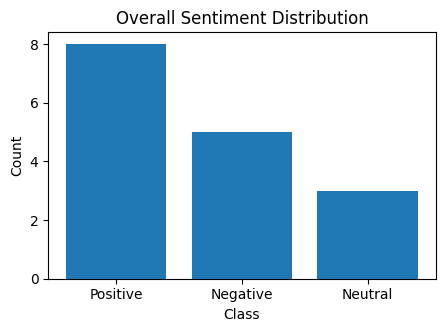


=== Top Features (mentions | +pos / -neg) ===
screen              :    2  |  +  1 / -  0
camera              :    2  |  +  1 / -  0
quality             :    2  |  +  0 / -  0
speaker             :    2  |  +  0 / -  0
performance         :    2  |  +  1 / -  0
customer            :    2  |  +  0 / -  0
delivery            :    2  |  +  0 / -  0
week                :    2  |  +  0 / -  0
battery             :    1  |  +  0 / -  0
life                :    1  |  +  0 / -  0
price               :    1  |  +  0 / -  0
bit                 :    1  |  +  0 / -  0
display             :    1  |  +  0 / -  0
design              :    1  |  +  0 / -  0
support             :    1  |  +  0 / -  0


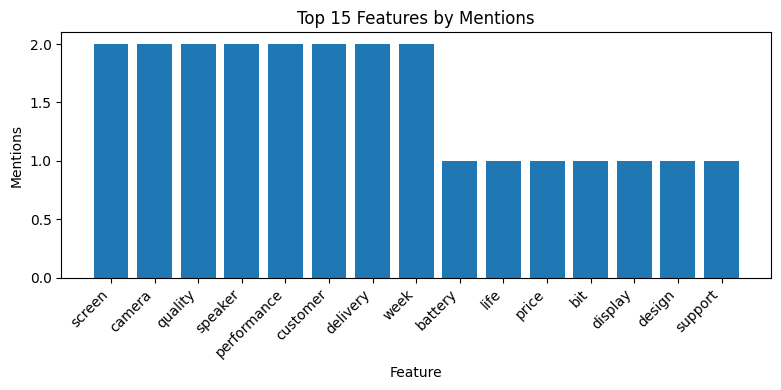


=== Key Entities (Top 10 each) ===
Brand   : [('Apple', 1), ('Dell', 1), ('Lenovo', 1), ('Amazon', 1), ('Samsung', 1), ('JBL', 1), ('Nokia', 1)]
Origin  : [('Bangalore', 1)]
Component: [('3 days', 1), ('Pixel', 1), ('a week', 1)]

=== Common Praises & Complaints per Feature (top 3 phrases) ===

Feature: screen
  Praises   : [('amazing amazing screen', 1)]
  Complaints: —

Feature: camera
  Praises   : [('Fantastic Fantastic camera', 1)]
  Complaints: —

Feature: quality
  Praises   : —
  Complaints: —

Feature: speaker
  Praises   : —
  Complaints: —

Feature: performance
  Praises   : [('better better performance', 1)]
  Complaints: —

Feature: customer
  Praises   : —
  Complaints: —

Feature: delivery
  Praises   : —
  Complaints: —

Feature: week
  Praises   : —
  Complaints: —

Feature: battery
  Praises   : —
  Complaints: —

Feature: life
  Praises   : —
  Complaints: —

[Approach A complete]


In [ ]:
# --------- YOUR DATA ---------
custom_reviews = [
    "The battery life is excellent but the screen is too dim outdoors.",
    "Fantastic camera and build quality. However, the speakers are disappointing.",
    "Average performance. The price is a bit high for what you get.",
    "Love the display and the design. Customer support from the brand was helpful.",
    "Poor charging speed and the software feels buggy.",
    "Apple's latest iPhone has an amazing screen and super fast processor.",
    "The Dell laptop is reliable and runs quietly, but the touchpad feels cheap.",
    "Great value for money. Lenovo did a good job with this budget-friendly model.",
    "The packaging from Amazon was damaged and delayed my delivery by 3 days.",
    "Horrible customer service from Samsung — no response for over a week.",
    "The JBL speakers deliver crystal clear sound. I'm impressed!",
    "The plastic feels flimsy and the back cover creaks under pressure.",
    "I was expecting better camera performance in low light from this Pixel device.",
    "The build quality reminds me of Nokia phones — solid and durable.",
    "Bought this in Bangalore. The delivery was fast and smooth.",
    "The charging cable broke within a week. Very disappointed with the accessories."
]

sentiment_counts, feature_stats, entity_counts, praises, complaints = init_structs()

for txt in custom_reviews:
    if isinstance(txt, str) and txt.strip():
        process_review_text(txt, sentiment_counts, feature_stats, entity_counts, praises, complaints)

summarize(sentiment_counts, feature_stats, entity_counts, praises, complaints)
print("\n[Approach A complete]")


# ========= Approach B: NLTK CORPUS =========

=== Overall Sentiment Distribution ===
Positive:  84.98%  (266/313)
Negative:  13.10%  (41/313)
Neutral :   1.92%  (6/313)


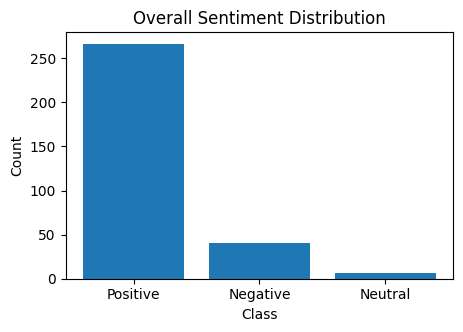


=== Top Features (mentions | +pos / -neg) ===
player              :  436  |  + 32 / -  0
camera              :  361  |  + 36 / -  1
phone               :  271  |  + 24 / -  1
software            :  185  |  + 14 / -  1
battery             :  178  |  +  1 / -  2
dvd                 :  166  |  +  0 / -  0
quality             :  163  |  + 23 / -  2
picture             :  159  |  + 19 / -  1
problem             :  158  |  +  2 / - 33
feature             :  154  |  + 33 / -  0
time                :  147  |  +  0 / -  1
thing               :  137  |  + 18 / -  6
zen                 :  117  |  +  5 / -  0
song                :  117  |  +  0 / -  1
music               :  110  |  +  2 / -  0
price               :  105  |  +  7 / -  5
button              :   95  |  +  1 / -  3
product             :   95  |  + 13 / -  2
file                :   94  |  +  0 / -  0
mp3                 :   89  |  +  0 / -  0


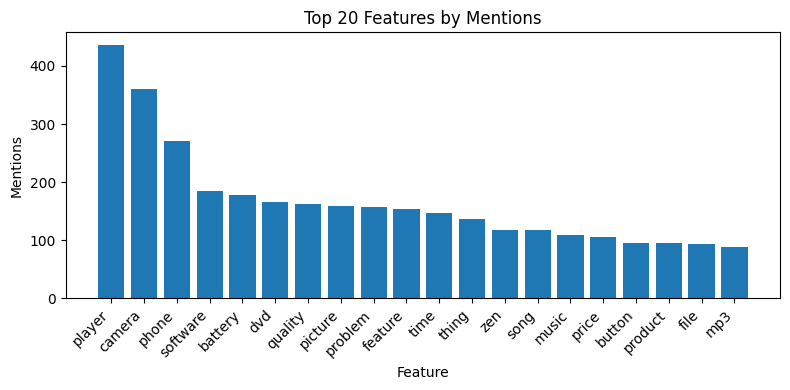


=== Key Entities (Top 10 each) ===
Brand   : [('nokia', 26), ('sony', 20), ('xtra', 20), ('samsung', 10), ('usb', 6), ('nikon', 5), ('motorola', 5), ('gsm', 5), ('mp3s', 4), ('kodak', 4)]
Origin  : [('apex', 7), ('europe', 5), ('south africa', 3), ('uk', 1), ('caribbean', 1), ('mass', 1), ('baghdad', 1), ('us', 1), ('coolpix4300', 1), ('detroit', 1)]
Component: [('one', 105), ('first', 72), ('2', 72), ('1', 56), ('4', 55), ('two', 49), ('3', 45), ('5', 35), ('second', 29), ('christmas', 28)]

=== Common Praises & Complaints per Feature (top 3 phrases) ===

Feature: player
  Praises   : [('good good player', 6), ('best best player', 4), ('great great player', 3)]
  Complaints: —

Feature: camera
  Praises   : [('great great camera', 6), ('best best camera', 5), ('best digital best digital camera', 2)]
  Complaints: [('defective defective camera', 1)]

Feature: phone
  Praises   : [('great great phone', 7), ('best best phone', 3), ('excellent excellent phone', 2)]
  Complaints: [('annoy

In [ ]:
import nltk
try:
    nltk.data.find("corpora/product_reviews_1")
except LookupError:
    nltk.download("product_reviews_1", quiet=True)

from nltk.corpus import product_reviews_1

# Load and join reviews properly
reviews_texts = []
for rv in product_reviews_1.reviews():
    sentences = [" ".join(words) for words in rv.sents()]  # ✅ join each sentence
    full_review = " ".join(sentences)
    if full_review.strip():
        reviews_texts.append(full_review)

# Optional: limit for speed
# reviews_texts = reviews_texts[:300]

# Initialize data structures
sentiment_counts, feature_stats, entity_counts, praises, complaints = init_structs()

# Process
for txt in reviews_texts:
    process_review_text(txt, sentiment_counts, feature_stats, entity_counts, praises, complaints)

# Summarize
summarize(sentiment_counts, feature_stats, entity_counts, praises, complaints, top_n_feats=20)
print("\n[Approach B complete]")

